<a href="https://colab.research.google.com/github/FaiOnayq/Bootcamp_W4_Assignments/blob/main/plants_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yudhaislamisulistya/plants-type-datasets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plants-type-datasets' dataset.
Path to dataset files: /kaggle/input/plants-type-datasets


In [ ]:
ls /kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants

Test_Set_Folder/  Train_Set_Folder/  Validation_Set_Folder/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ls /kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder

 aloevera/     corn/       guava/       paddy/          soybeans/
 banana/       cucumber/   kale/        papaya/         spinach/
 bilimbi/      curcuma/    longbeans/  'peper chili'/  'sweet potatoes'/
 cantaloupe/   eggplant/   mango/       pineapple/      tobacco/
 cassava/      galangal/   melon/       pomelo/         waterapple/
 coconut/      ginger/     orange/      shallot/        watermelon/


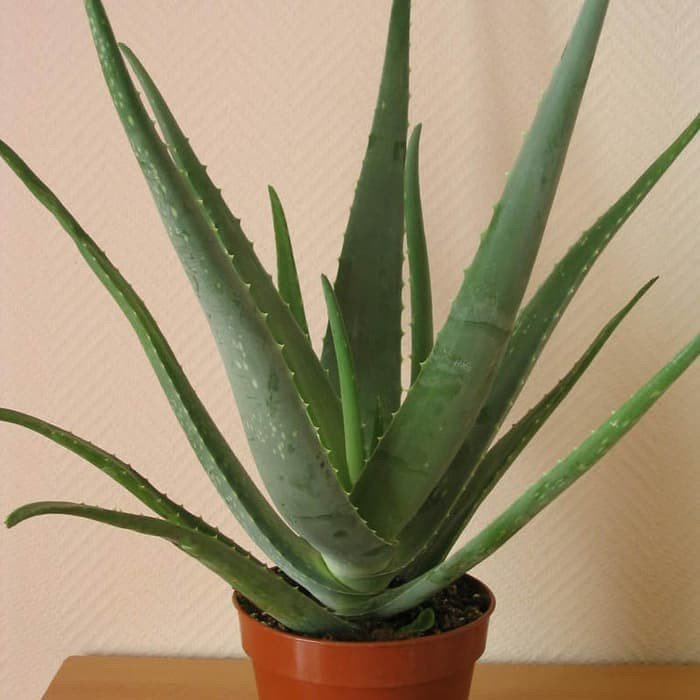

In [ ]:
Image.open("//kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder/aloevera/aloevera415.jpg")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = datasets.ImageFolder('/kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder', transform=transform)
test_data = datasets.ImageFolder('/kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Test_Set_Folder', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
image, label = train_data[0]
print(image.shape, label)
print("length of train dataset", len(train_data))
print("length of test dataset", len(test_data))

torch.Size([3, 128, 128]) 0
length of train dataset 23972
length of test dataset 2998


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class PlantCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.stage1 = ConvBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.stage2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.stage3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.stage4 = ConvBlock(256, 512)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.pool1(self.stage1(x))
        x = self.pool2(self.stage2(x))
        x = self.pool3(self.stage3(x))
        x = self.stage4(x)
        x = self.gap(x)
        return self.classifier(x)

num_classes = len(train_data.classes)
model = PlantCNN(num_classes)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for epoch in range(20):
  model.train()
  total_loss = 0
  correct = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    correct += (outputs.argmax(1) == labels).sum().item()

  train_loss = total_loss / len(train_loader)
  train_acc = correct / len(train_data)
  print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")

cuda
Epoch 1, Loss: 1687.2964, Accuracy: 0.3243
Epoch 2, Loss: 1295.0368, Accuracy: 0.4647
Epoch 3, Loss: 1096.7779, Accuracy: 0.5385
Epoch 4, Loss: 950.4255, Accuracy: 0.5976
Epoch 5, Loss: 835.4247, Accuracy: 0.6418
Epoch 6, Loss: 736.5201, Accuracy: 0.6822
Epoch 7, Loss: 663.1022, Accuracy: 0.7110
Epoch 8, Loss: 583.9633, Accuracy: 0.7461
Epoch 9, Loss: 540.0360, Accuracy: 0.7606
Epoch 10, Loss: 481.9210, Accuracy: 0.7884
Epoch 11, Loss: 430.2949, Accuracy: 0.8093
Epoch 12, Loss: 400.6943, Accuracy: 0.8196
Epoch 13, Loss: 356.1696, Accuracy: 0.8402
Epoch 14, Loss: 329.2379, Accuracy: 0.8532
Epoch 15, Loss: 308.4051, Accuracy: 0.8629
Epoch 16, Loss: 274.1700, Accuracy: 0.8774
Epoch 17, Loss: 266.2117, Accuracy: 0.8792
Epoch 18, Loss: 236.8628, Accuracy: 0.8920
Epoch 19, Loss: 227.8015, Accuracy: 0.8953
Epoch 20, Loss: 213.3356, Accuracy: 0.9020


In [ ]:
model.eval()
correct = 0

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    correct += (outputs.argmax(1) == labels).sum().item()

val_acc = correct / len(test_data)
print(f"Test Accuracy: {val_acc:.4f}")
torch.save(model.state_dict(), "model_weights.pth")

Test Accuracy: 0.9093
